<a href="https://colab.research.google.com/github/MichalHalicki4/LinAR-interpolation/blob/main/althydro_st_corr_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import scipy
import math

In [ ]:
home = '/content/'
window = 120
sig_lvl = .05
basins = {
1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28],
2: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28],
3: [3, 4, 5, 6, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 25, 26, 27, 28],
4: [4, 5, 6, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 25, 26, 27, 28],
5: [5, 6, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 25, 26, 27, 28],
6: [6, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 25, 26, 27, 28]
}

imgw_df = pd.read_csv(home + 'pred_gauge_1_2016-01-01_2022-05-31.csv', sep=';', header=0, index_col=['Unnamed: 0'], parse_dates=True)
typical_freq = pd.to_timedelta(np.diff(imgw_df.index)).value_counts().index[0]
imgw_df =  imgw_df.resample(typical_freq).fillna(method=None)

In [ ]:
def get_gauge_data_cut(df, gauge, t, w):
  return df[gauge].loc[t: t + timedelta(seconds=3600 * (w-1))]

**Funkcje LinAR do różnicowania danych**

In [ ]:
def difference(data_to_diff: pd.Series, step: timedelta):
    """
    :param data_to_diff: time series to be differenced
    :param step: index step of the data
    :return: differenced time series
    """
    diff = data_to_diff[1:].copy()
    index_range = data_to_diff.index[1:]
    for idx in index_range:
        val = data_to_diff.loc[idx] - data_to_diff.loc[idx - step]
        diff.at[idx] = val
    return diff


def f_test(timeseries: pd.Series):
    """
    This function performs the ftset, which aims to assess data stationarity by comparing variances of the first and
    second half of the time series.

    :param timeseries: time series on which the ftest will be applied
    :return: p value of the ftest.
    """
    timeseries = timeseries.to_list()
    split = round(len(timeseries) / 2)
    x1, x2 = timeseries[0:split], timeseries[split:]
    if len(x1) > len(x2):
        x1 = timeseries[1:split]
    x, y = np.array(x1), np.array(x2)
    var1, var2 = sorted([np.var(x1, ddof=1), np.var(x2, ddof=1)])
    if var1 == 0 or var2 == 0:
      return 0  # returned p_val = 0 means, that the variances are significantly different, since one of them is equal to zero.
    f = var2 / var1
    nun = x.size - 1
    dun = y.size - 1
    p_value = 1 - scipy.stats.f.cdf(f, nun, dun)
    return p_value


def get_stationary_data(timeseries: pd.Series, step: timedelta, sig_adf: float, sig_ft: float, num_of_diffs: int):
    """
    This function aims to obtain stationary data by differencing it.
    The stationarity is tested with the use of the Augmented Dickey Fuller (ADF) test and Ftest.
    The differencing is performed in a while loop until stationarity is obtained,
    or the number of differencings reaches the threshold defined by the num_of_diffs parameter.

    :param timeseries: time series, the stationarity of which should be obtained.
    :param step: index step of the data
    :param sig_adf: the significance level for the ADF test.
    :param sig_ft: the significance level for the Ftest.
    :param num_of_diffs: Number of differencings allowed in the while loop.
    :return: a list of at least two pd.Series: the undifferenced data and the 1st order differenced data.
             In the case of multiple differencing, successive time series are added to the list.
    """
    diff, diffs_list = difference(timeseries, step), [timeseries]
    diffs_list.append(diff)
    p_val_adf = adfuller(diff)[1]
    p_val_ftest = f_test(diff)
    while p_val_adf > sig_adf or p_val_ftest < sig_ft:
        diff = difference(diff, step)
        diffs_list.append(diff)
        if len(diffs_list) > num_of_diffs+1:
            return None
        p_val_adf = adfuller(diff)[1]
        p_val_ftest = f_test(diff)
    return diffs_list

**Funkcje TN do kross-korelacji**

In [ ]:
def normalize_two_ts(firs_ts, second_ts):
    first_normalized = (firs_ts - np.mean(firs_ts)) / (np.std(firs_ts) * len(firs_ts))
    second_normalized = (second_ts - np.mean(second_ts)) / (np.std(second_ts))
    return first_normalized, second_normalized


def r_to_z(r):
    try:
        return math.log((1 + r) / (1 - r)) / 2.0
    except:
        return 'error'

def z_to_r(z):
    e = math.exp(2 * z)
    return (e - 1) / (e + 1)


def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    if z == 'error':
        return 'error'
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return z_to_r(lo), z_to_r(hi)


def check_cross_correlations(a: np.array, b: np.array, alp: float):
    # normalizacja wektorow (aby korelacja byla znormaliowana, a nie liczyla sie tylko kowariancja)
    a, b = normalize_two_ts(a, b)

    # obliczenie przedzialu ufnosci dla korelacji = 0, czyli tak jak w jezyku R dla funkcji ccf
    conf_int_r0 = r_confidence_interval(0, alp, len(a))
    if conf_int_r0 == 'error':
        return [False, True]

    # korelacja wzajemna metoda z scipy
    cross_corr = scipy.signal.correlate(a, b)

    # petla tworzaca wektory przedzialu ufnosci dla korelacji = 0 (powyzej) oraz dla kazdej korelacji dla konkretnej korelacji dla danego lag
    upper_conf_int, lower_conf_int, upper_conf_int_r0, lower_conf_int_r0 = [], [], [], []
    for i in range(len(cross_corr)):
        conf_int = r_confidence_interval(cross_corr[i], alp, len(a))
        upper_conf_int.append(conf_int[1])
        lower_conf_int.append(conf_int[0])
        upper_conf_int_r0.append(conf_int_r0[1])
        lower_conf_int_r0.append(conf_int_r0[0])

    # test czy korelacja wzajemna jest istotna (warunek standardowy)
    offset_around_upper_conf_int_r0 = cross_corr - upper_conf_int_r0
    offset_around_lower_conf_int_r0 = cross_corr - lower_conf_int_r0

    if any(offset > 0 for offset in offset_around_upper_conf_int_r0):
        flag = [True, False]
    elif any(offset < 0 for offset in offset_around_lower_conf_int_r0):
        flag = [True, False]
    else:
        flag = [False, False]
    return flag

**Funkcja do sprawdzania stacjonarności i zapisywania ich do dictionary**

In [ ]:
def check_stationarity(ts, freq, sig_level):
  if ts.isna().any():
    return {'no_data': True, 'stationary_1': pd.Series(dtype='float64'),  'stationary_2': pd.Series(dtype='float64'), 'stationary_3': pd.Series(dtype='float64'), 'not_stationary': False}
  diff_1 = difference(ts, freq)
  diff_2 = difference(diff_1, freq)
  diff_3 = difference(diff_2, freq)

  p_val_adf = adfuller(diff_1)[1]
  p_val_ftest = f_test(diff_1)

  p_val_adf_2 = adfuller(diff_2)[1]
  p_val_ftest_2 = f_test(diff_2)

  p_val_adf_3 = adfuller(diff_3)[1]
  p_val_ftest_3 = f_test(diff_3)

  cond1 = p_val_adf < sig_level and p_val_ftest > sig_level
  cond2 = p_val_adf_2 < sig_level and p_val_ftest_2 > sig_level
  cond3 = p_val_adf_3 < sig_level and p_val_ftest_3 > sig_level
  # print(ts, p_val_adf, p_val_adf_2, p_val_adf_3, p_val_ftest, p_val_ftest_2, p_val_ftest_3)
  res_dict = {'no_data': False, 'stationary_1': pd.Series(dtype='float64'),  'stationary_2': pd.Series(dtype='float64'), 'stationary_3': pd.Series(dtype='float64'), 'not_stationary': False}

  if cond1:
    res_dict['stationary_1'] = [ts, diff_1]
  if cond2:
    res_dict['stationary_2'] = [ts, diff_1, diff_2]
  if cond3:
    res_dict['stationary_3'] = [ts, diff_1, diff_2, diff_3]
  if not any([cond1, cond2, cond3]):
    res_dict['not_stationary'] = True
  return res_dict

**Funkcja do zwracania takiego poziomu różnicowania, dla którego (1) prediction gauge będzie stacjonarne i (2) najwięcej pozostałych wodowskazów też będzie stacjonarne.**

In [ ]:
def get_most_stationary_val(diffs_results, prediction_g, st_nums):
  # print(diffs_results)
  if diffs_results[prediction_g]['no_data']:
    return 'no_data'
  if diffs_results[prediction_g]['not_stationary']:
    # print('!!!----!!!')
    return 'not_stationary'
  stationarities_sorted = list(dict(sorted(st_nums.items(), key=lambda x: x[1], reverse=True)).keys())
  if len(diffs_results[prediction_g][stationarities_sorted[0]]) > 0:
    most_stationary = stationarities_sorted[0]
  elif len(diffs_results[prediction_g][stationarities_sorted[1]]) > 0:
    most_stationary = stationarities_sorted[1]
  elif len(diffs_results[prediction_g][stationarities_sorted[2]]) > 0:
    most_stationary = stationarities_sorted[2]
  return most_stationary

**Funkcja zwracająca słownik z szeregami czasowymi dla stacji, które są skorelowane z prediction gauge.**

In [ ]:
def get_correlated_gauges(prediction_g, gauges, most_stationary, sig_level):
  not_correlated_li = []
  pred_gauge_ts = gauges[prediction_g][most_stationary][-1].dropna().to_numpy()
  for g, v in gauges.items():
    if not check_cross_correlations(pred_gauge_ts, v[most_stationary][-1].dropna().to_numpy(), sig_level)[0]:
      not_correlated_li.append(g)
  return {k: v for k, v in gauges.items() if k not in not_correlated_li}

**Funkcje  uzupełniające słownik z zapisanymi statystykami corr i st dla stacji w zlewni.**

In [ ]:
def update_results_dict(res, t, g_in_basin, valid_g):
  for g in g_in_basin:
    if g in valid_g:
      res[t][g] = 1
    else:
      res[t][g] = 0


def update_results_if_no_prognosis(res, t, g_in_basin, txt):
  res[t][txt] = 1
  for x in g_in_basin:
    res[t][x] = 0

**Sprawdzanie, ile stacji przejdzie przez dwa sita: stacjonarności i kross-korelacji**

In [ ]:
def analyse_st_corr(pred_g, data_df, wdw, sig_level, freq, dt1, dt2):
  results = {}
  gauges_in_basin = basins[pred_g]
  for t0 in data_df.loc[dt1:dt2].index:
    diffs_dict = {}
    results[t0] = {'no_data': 0, 'not_stationary': 0}
    for g in gauges_in_basin:
      data_cut = get_gauge_data_cut(data_df, str(g), t0, wdw)
      diffs_dict[g] = check_stationarity(data_cut, freq, sig_level)
      # print(g, diffs_dict[g]['not_stationary'])
    st_summary = {'stationary_1': 0, 'stationary_2': 0, 'stationary_3':0}
    for g in gauges_in_basin:
      if len(diffs_dict[g]['stationary_1']) > 0:
        st_summary['stationary_1'] += 1
      if len(diffs_dict[g]['stationary_2']) > 0:
        st_summary['stationary_2'] += 1
      if len(diffs_dict[g]['stationary_3']) > 0:
        st_summary['stationary_3'] += 1

    most_stationary_val = get_most_stationary_val(diffs_dict, pred_g, st_summary)
    if most_stationary_val in ['no_data', 'not_stationary']:
      update_results_if_no_prognosis(results, t0, gauges_in_basin, most_stationary_val)
      continue
    stationary_basin_ts = {k: v for k, v in diffs_dict.items() if len(v[most_stationary_val]) > 0}
    valid_gauges = get_correlated_gauges(pred_g, stationary_basin_ts, most_stationary_val, sig_level)
    update_results_dict(results, t0, gauges_in_basin, valid_gauges.keys())
    # print(t0)
    if t0.day == 1:
      print(t0)
      df = pd.DataFrame.from_dict(results, orient='index')
      df.to_csv(f'st_corr_analysis_gauge{pred_g}_{dt1}_{dt2}.csv', sep=';')
  df = pd.DataFrame.from_dict(results, orient='index')
  df.to_csv(f'st_corr_analysis_gauge{pred_g}_{dt1}_{dt2}.csv', sep=';')

In [ ]:
analyse_st_corr(1, imgw_df, window, sig_lvl, typical_freq, '2016-01-02', '2016-01-04')

<ipython-input-80-a746e033d377>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return math.log((1 + r) / (1 - r)) / 2.0
<ipython-input-80-a746e033d377>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return math.log((1 + r) / (1 - r)) / 2.0
<ipython-input-80-a746e033d377>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return math.log((1 + r) / (1 - r)) / 2.0
<ipython-input-80-a746e033d377>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return math.log((1 + r) / (1 - r)) / 2.0
<ipython-input-80-a746e033d377>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return math.log((1 + r) / (1 - r)) / 2.0
<ipython-input-80-a746e033d377>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return math.log((1 + r) / (1 - r)) / 2.0
<ipython-input-80-a746e033d377>:9: RuntimeWarning: divide by zero encountered in double_scalars
  return math.log((1 + r) / (1 - r)) / 2.0
<ipython-input-80-a746e033d



---
---
---

**W tym skrypcie generuję wykres słupkowy, w którym pokazuję wyniki analizy stacjonarności.**


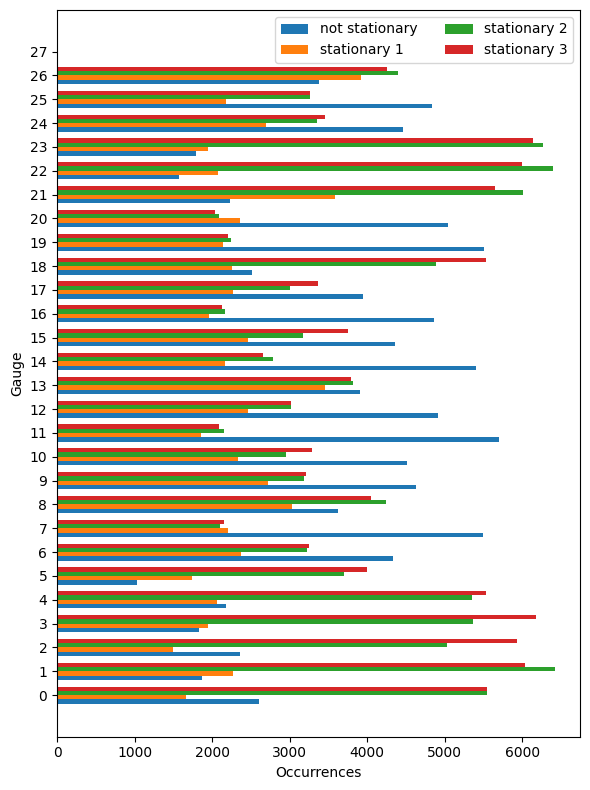

In [ ]:
df = pd.DataFrame.from_dict(res_dict, orient='index')
# df = pd.read_csv(home + 'stationarity_2016-01-01x2017-01-01_120_05.csv', sep=';')
fig, ax = plt.subplots(figsize=(6, 8))
labels = df.index.to_list()
n = len(labels)
r = np.arange(n)
width = 0.18
ax.barh(r - 1.5*width, df['not_stationary'].to_list(), height=width, label='not stationary')
ax.barh(r - .5*width, df['stationary_1'].to_list(), height=width, label='stationary 1')
ax.barh(r + .5*width, df['stationary_2'].to_list(), height=width, label='stationary 2')
ax.barh(r + 1.5*width, df['stationary_3'].to_list(), height=width, label='stationary 3')

ax.set_yticks(r)
ax.set_yticklabels(labels)
# ax.set_xlim(-1,n+1)
ax.set_xlabel('Occurrences')
ax.set_ylabel('Gauge')
ax.legend(ncol=2)
fig.tight_layout()
plt.show()

In [ ]:
no_st = df['not_stationary'].mean()
st1 = df['stationary_1'].mean()
st2 = df['stationary_2'].mean()
st3 = df['stationary_3'].mean()
print(no_st, st1, st2, st3)

3531.75 2271.5 3789.964285714286 3873.6428571428573
